In [113]:
import wisardpkg as wp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import fnmatch
import scipy.stats as stats
import seaborn as sns

from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [114]:
set_a = pd.read_csv("heart_sounds/set_a.csv")
set_b = pd.read_csv("heart_sounds/set_b.csv")

In [115]:
#merge both set-a and set-b
dataframes = [set_a, set_b]
train_ab = pd.concat(dataframes)
train_ab.describe()

,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_b/Btraining_normal_154_1306935608852_B.wav,normal,noisynormal
freq,656,1,351,120


<AxesSubplot:>

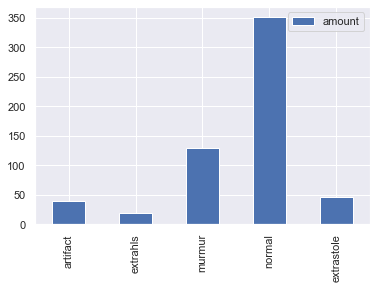

In [116]:
from collections import Counter
letter_counts = Counter(train_ab['label'].dropna())
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df = df.rename(columns={0: "amount"})
df.plot.bar()

No handles with labels found to put in legend.


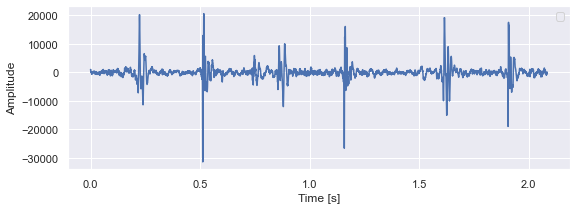

In [117]:
samplerate, data = wavfile.read('heart_sounds/set_b/extrastole__202_1308145175747_C2.wav')
length = data.shape[0] / samplerate
time = np.linspace(0., length, data.shape[0])
plt.figure(figsize=(9, 3))
plt.plot(time, data)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [118]:
# Testing mfccs
y, sr = librosa.load('heart_sounds/set_a/normal__201108011118.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=40)
mels_DB = librosa.power_to_db(mels, ref=np.max)

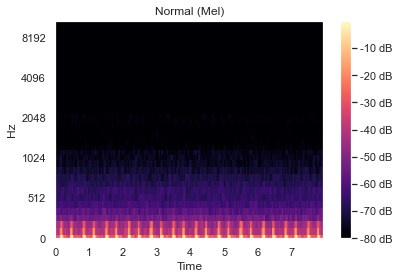

In [119]:
librosa.display.specshow(mels_DB, sr=sr, x_axis='time', y_axis='mel')
plt.title('Normal (Mel)')
plt.colorbar(format='%+2.0f dB')

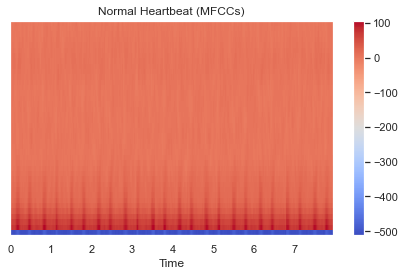

In [120]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Normal Heartbeat (MFCCs)')
plt.tight_layout()

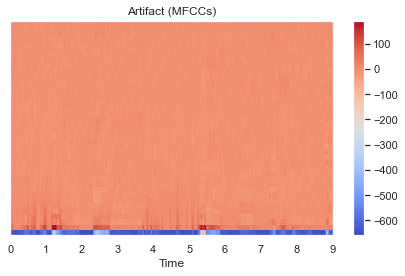

In [121]:
y, sr = librosa.load('heart_sounds/set_a/artifact__201012172012.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=40)
mels_DB = librosa.power_to_db(mels, ref=np.max)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Artifact (MFCCs)')
plt.tight_layout()

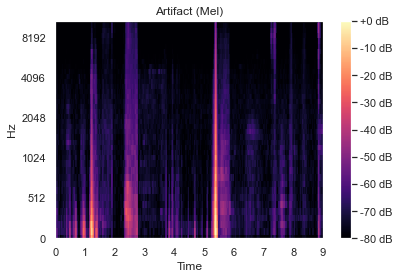

In [122]:
librosa.display.specshow(mels_DB, sr=sr, x_axis='time', y_axis='mel')
plt.title('Artifact (Mel)')
plt.colorbar(format='%+2.0f dB')

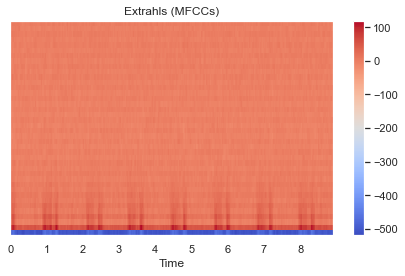

In [123]:
y, sr = librosa.load('heart_sounds/set_a/extrahls__201101070953.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=40)
mels_DB = librosa.power_to_db(mels, ref=np.max)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Extrahls (MFCCs)')
plt.tight_layout()

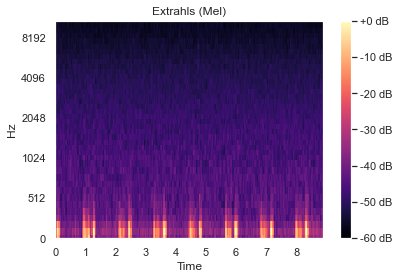

In [124]:
librosa.display.specshow(mels_DB, sr=sr, x_axis='time', y_axis='mel')
plt.title('Extrahls (Mel)')
plt.colorbar(format='%+2.0f dB')

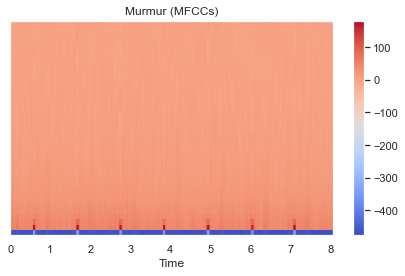

In [125]:
y, sr = librosa.load('heart_sounds/set_a/murmur__201101180902.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=40)
mels_DB = librosa.power_to_db(mels, ref=np.max)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Murmur (MFCCs)')
plt.tight_layout()

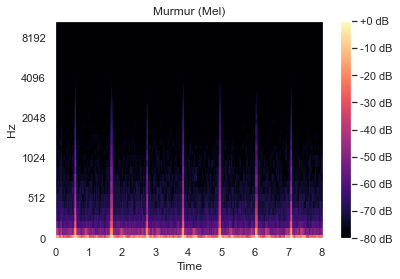

In [126]:
librosa.display.specshow(mels_DB, sr=sr, x_axis='time', y_axis='mel')
plt.title('Murmur (Mel)')
plt.colorbar(format='%+2.0f dB')

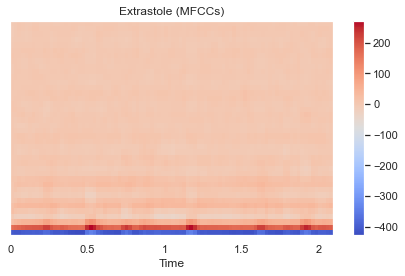

In [127]:
y, sr = librosa.load('heart_sounds/set_b/extrastole__202_1308145175747_C2.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=40)
mels_DB = librosa.power_to_db(mels, ref=np.max)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Extrastole (MFCCs)')
plt.tight_layout()

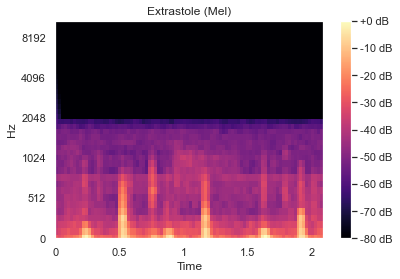

In [128]:
librosa.display.specshow(mels_DB, sr=sr, x_axis='time', y_axis='mel')
plt.title('Extrastole (Mel)')
plt.colorbar(format='%+2.0f dB')

In [129]:
def load_file_data_sum(folder, file_names, duration=12, sr=22050, mels_spec=False):
    input_length=sr*duration
    freq = []
    mag = []
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            X, sr = librosa.load(sound_file, sr=sr, duration=duration, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            if (round(dur) < duration):
                X = librosa.util.fix_length(X, input_length)

            fft = np.fft.fft(X)
            magnitude = np.abs(fft)
            frequency = np.linspace(0, sr, len(magnitude)) 
            
            if mels_spec:
                #S = librosa.stft(X)
                mels = librosa.feature.melspectrogram(X, sr=sr, n_mels=40)
                mels_sum = np.cumsum(mels, axis=1)
                mels_zscore = stats.zscore(mels_sum)
                mels_tanh = np.tanh(mels_zscore)
                #magnitude_mels = np.abs(mels)**2
                #mel = librosa.filters.mel(sr=sr)
                kc = wp.KernelCanvas(len(mels_tanh[0]), 50)
                out = kc.transform(mels_tanh)
            
            else:
                
                mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40, dct_type=3)               
                mfccs_sum = np.cumsum(mfccs, axis=1)
                mfccs_zscore = stats.zscore(mfccs_sum)
                mfccs_tanh = np.tanh(mfccs_zscore)
                kc = wp.KernelCanvas(len(mfccs_tanh[0]), 50)
                out = kc.transform(mfccs_tanh)  
        except Exception as e:
            print("Error encountered while parsing file: ", e)        
        data.append(out)
        mag.append(magnitude)
        freq.append(frequency)
    return data, mag, freq

In [281]:
DURATION_SEG = 12
input_dir = 'heart_sounds'
A_folder = input_dir+'/set_a/'

A_artifact_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'artifact*.wav')
A_artifact_sounds, A_art_mag, A_art_freq = load_file_data_sum(folder=A_folder, file_names=A_artifact_files, duration=DURATION_SEG, mels_spec=True)
A_artifact_labels = ['artifact' for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'normal*.wav')
A_normal_sounds, A_nor_mag, A_nor_freq = load_file_data_sum(folder=A_folder, file_names=A_normal_files, duration=DURATION_SEG, mels_spec=True)
A_normal_labels = ['normal' for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds, A_hls_mag, A_hls_freq = load_file_data_sum(folder=A_folder, file_names=A_extrahls_files, duration=DURATION_SEG, mels_spec=True)
A_extrahls_labels = ['extrahls' for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'murmur*.wav')
A_murmur_sounds, A_mur_mag, A_mur_freq = load_file_data_sum(folder=A_folder, file_names=A_murmur_files, duration=DURATION_SEG, mels_spec=True)
A_murmur_labels = ['murmur' for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(input_dir+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds, A_unl_mag, A_unl_freq = load_file_data_sum(folder=A_folder,file_names=A_unlabelledtest_files, duration=DURATION_SEG, mels_spec=True)
A_unlabelledtest_labels = ['unlabelledtest' for items in A_unlabelledtest_sounds]


In [282]:
input_dir = 'heart_sounds'
B_folder = input_dir+'/set_b/'

B_normal_files = fnmatch.filter(os.listdir(input_dir+'/set_b'), 'normal*.wav')
B_normal_sounds, B_nor_mag, B_nor_freq = load_file_data_sum(folder=B_folder, file_names=B_normal_files, duration=DURATION_SEG, mels_spec=True)
B_normal_labels = ['normal' for items in B_normal_sounds]

B_extrastole_files = fnmatch.filter(os.listdir(input_dir+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds, B_sto_mag, B_sto_freq = load_file_data_sum(folder=B_folder, file_names=B_extrastole_files, duration=DURATION_SEG, mels_spec=True)
B_extrastole_labels = ['extrastole' for items in B_extrastole_sounds]

B_murmur_files = fnmatch.filter(os.listdir(input_dir+'/set_b'), 'murmur*.wav')
B_murmur_sounds, B_mur_mag, B_mur_freq = load_file_data_sum(folder=B_folder, file_names=B_murmur_files, duration=DURATION_SEG, mels_spec=True)
B_murmur_labels = ['murmur' for items in B_murmur_files]

# test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(input_dir+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds, B_unl_mag, B_unl_freq = load_file_data_sum(folder=B_folder,file_names=B_unlabelledtest_files, duration=DURATION_SEG, mels_spec=True)
B_unlabelledtest_labels = ['unlabelledtest' for items in B_unlabelledtest_sounds]


In [283]:
#combine set-a and set-b 
x_data = np.concatenate((A_artifact_sounds, A_murmur_sounds, A_normal_sounds, A_extrahls_sounds,
                         B_murmur_sounds, B_normal_sounds, B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_murmur_labels, A_normal_labels, A_extrahls_labels,
                         B_murmur_labels, B_normal_labels, B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds, B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels, B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


In [284]:
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, 
#shuffle=True,
random_state=2
)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

In [292]:
model = wp.Wisard(20)
model.train(x_train, y_train)
y_pred = model.classify(x_test)
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score: ", acc_score)

Accuracy score:  0.9914529914529915


In [286]:
sec_accuracy_mfcc = [0.8632478632478633, 0.9487179487179487, 0.9401709401709402, 0.9572649572649573, 0.9572649572649573,
0.9572649572649573, 0.9743589743589743, 0.9658119658119658, 0.9658119658119658, 0.9914529914529915, 0.9743589743589743,
0.9914529914529915]
sec_accuracy_mel = []
accs = list()
for address_size in range(2, 40):
    model = wp.Wisard(address_size)
    model.train(x_train, y_train)
    y_pred = model.classify(x_test)
    accs.append(accuracy_score(y_test, y_pred))

<AxesSubplot:title={'center':'MFCC'}, xlabel='addressSize', ylabel='accuracy'>

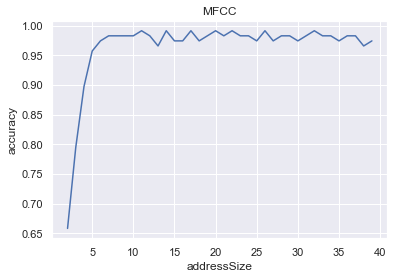

In [287]:
sns.set(style="darkgrid")
graph_data = {'addressSize': [i for i in range(2, 40)], 'accuracy': accs}
plt.title('MFCC')
sns.lineplot(data=graph_data, x='addressSize', y='accuracy')

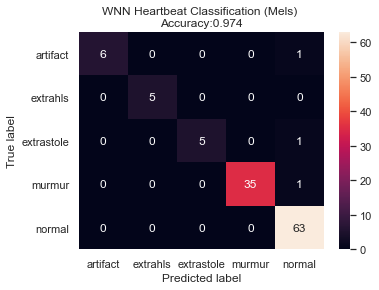

In [288]:
# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                    index = ['artifact','extrahls','extrastole', 'murmur', 'normal'], 
                     columns = ['artifact','extrahls','extrastole', 'murmur', 'normal'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('WNN Heartbeat Classification (Mels) \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [289]:
B_mur_mag = [np.pad(item, (0, 110250-len(item)), 'constant') if len(item) < 110250 else item for item in B_mur_mag]
B_mur_mag_mean = np.mean(B_mur_mag, axis=0)

C:\Users\Rodrigo\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (264600,) (262473,) 

<function matplotlib.pyplot.show(close=None, block=None)>

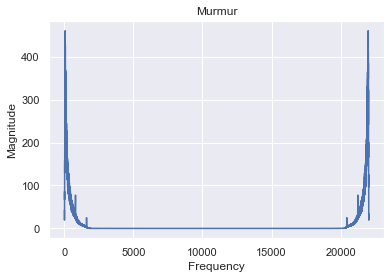

In [ ]:
plt.plot(B_mur_freq[0], B_mur_mag_mean)
plt.title("Murmur")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show

In [ ]:
A_hls_mag = [np.pad(item, (0, 110250-len(item)), 'constant') if len(item) < 110250 else item for item in A_hls_mag]
A_hls_mag_mean = np.mean(A_hls_mag, axis=0)

<function matplotlib.pyplot.show(close=None, block=None)>

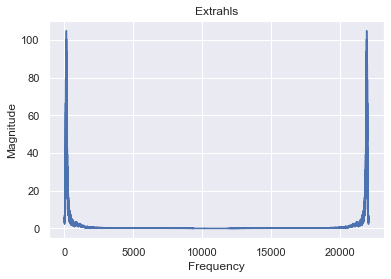

In [ ]:
plt.plot(A_hls_freq[0], A_hls_mag_mean)
plt.title("Extrahls")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show

In [ ]:
B_nor_mag = [np.pad(item, (0, 110250-len(item)), 'constant') if len(item) < 110250 else item for item in B_nor_mag]
B_nor_mag_mean = np.mean(B_nor_mag, axis=0)

C:\Users\Rodrigo\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (242550,) (235169,) 

<function matplotlib.pyplot.show(close=None, block=None)>

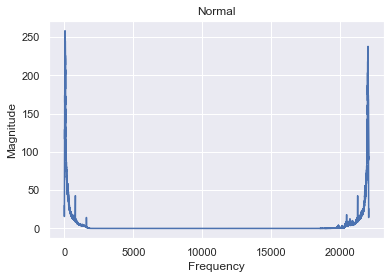

In [ ]:
plt.plot(B_nor_freq[0], B_nor_mag_mean)
plt.title("Normal")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show

In [ ]:
A_art_mag = [np.pad(item, (0, 110250-len(item)), 'constant') if len(item) < 110250 else item for item in A_art_mag]
A_art_mag_mean = np.mean(B_nor_mag, axis=0)

<function matplotlib.pyplot.show(close=None, block=None)>

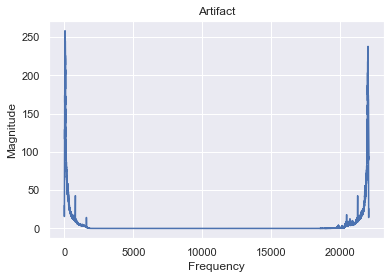

In [ ]:
plt.plot(A_art_freq[0], A_art_mag_mean)
plt.title("Artifact")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show

In [ ]:
B_sto_mag = [np.pad(item, (0, 110250-len(item)), 'constant') if len(item) < 110250 else item for item in B_sto_mag]
B_sto_mag_mean = np.mean(B_sto_mag, axis=0)

<function matplotlib.pyplot.show(close=None, block=None)>

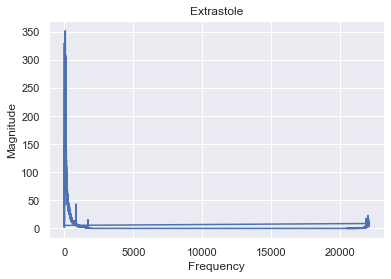

In [ ]:
B_sto_freq_0 = np.pad(B_sto_freq[0], (0, 110250-len(B_sto_freq[0])))
plt.plot(B_sto_freq_0, B_sto_mag_mean)
plt.title("Extrastole")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show